## Import Packages and Data 

In [1]:
import tensorflow as tf                  # TensorFlow
import tensorflow.nn as nn               # nn contains useful neural network functions like softmax, relu, tanh
from tensorflow import keras             # high level API for TensorFlow
import tensorflow.keras.layers as layers # contains layers like RNN, CNN, LSTM
import numpy as np                       # standard numerical python
# used to partition datasets
from sklearn.model_selection import train_test_split  

#####

import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape,Bidirectional,GRU
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
def data_split(X,Y,person):
    num_persons = 9 
    X_person = []
    Y_person = [] 
    
    for i in range(num_persons): 
        index = np.where(person == i)[0]

        X_person.append(X[index, :, :]) 
        Y_person.append(Y[index]) 
        
    return X_person, Y_person 

In [97]:
def data_prep(X,y,sub_sample,average,noise,trim=500):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:trim]
    #print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    #print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    #print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    #print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y

In [98]:
def preprocessing(X, Y, X_test, Y_test,trim=400):
    ## Splits a dataset into training and validation sets and pre-processes them
    #Set the cutoff time for the data
    #trim = 400
    
    ## Determine the size of the input 
    train_size = X.shape[0] 
    valid_size = int(np.ceil(train_size/6))
    
    ind_valid = np.random.choice(train_size, valid_size, replace=False)
    ind_train = np.array(list(set(range(train_size)).difference(set(ind_valid))))
    
    # Creating the training and validation sets using the generated indices
    (X_train, X_valid) = X[ind_train], X[ind_valid] 
    (y_train, y_valid) = Y[ind_train], Y[ind_valid]
      
    ## Preprocessing the dataset
    x_train,y_train = data_prep(X_train,y_train,2,2,True,trim)
    x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True,trim)
    X_test_prep,y_test_prep = data_prep(X_test,Y_test,2,2,True,trim)
    
    #print('Shape of training set:',x_train.shape)
    #print('Shape of validation set:',x_valid.shape)
    #print('Shape of training labels:',y_train.shape)
    #print('Shape of validation labels:',y_valid.shape)
    #print('Shape of testing set:',X_test_prep.shape)
    #print('Shape of testing labels:',y_test_prep.shape)
       
    # Converting the labels to categorical variables for multiclass classification
    y_train = to_categorical(y_train, 4)
    y_valid = to_categorical(y_valid, 4)
    y_test = to_categorical(y_test_prep, 4)
    #print('Shape of training labels after categorical conversion:',y_train.shape)
    #print('Shape of validation labels after categorical conversion:',y_valid.shape)
    #print('Shape of test labels after categorical conversion:',y_test.shape)
    
    # Adding width of the segment to be 1
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
    x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
    #print('Shape of training set after adding width info:',x_train.shape)
    #print('Shape of validation set after adding width info:',x_valid.shape)
    #print('Shape of test set after adding width info:',x_test.shape)

    # Reshaping the training and validation dataset
    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 1,2)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 1,2)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 1,2)
    #print('Shape of training set after dimension reshaping:',x_train.shape)
    #print('Shape of validation set after dimension reshaping:',x_valid.shape)
    #print('Shape of test set after dimension reshaping:',x_test.shape)
    
    return y_train, y_valid, y_test, x_train, x_valid, x_test

In [5]:
## Loading the dataset
X_test = np.load("X_test.npy")
Y_test = np.load("y_test.npy")
person_test = np.load("person_test.npy")
X_train_valid = np.load("X_train_valid.npy")
Y_train_valid = np.load("y_train_valid.npy")
person_train_valid = np.load("person_train_valid.npy")

## Adjust the dataset labels to be 0,1,2,3
Y_train_valid -= 769
Y_test -= 769 

## Split the dataset into those belonging to individual people 
Xp_train_valid, Yp_train_valid = data_split(X_train_valid, Y_train_valid, person_train_valid)
Xp_test, Yp_test = data_split(X_test, Y_test, person_test) 

## Preprocess Data 

In [68]:
## Preprocess a single person dataset 
person = 0  #Set which person you'd like to look at (from 0 to 8)

yp_train, yp_valid, yp_test, xp_train, xp_valid, xp_test = preprocessing(Xp_train_valid[person], Yp_train_valid[person], Xp_test[person], Yp_test[person])



In [ ]:
## Preprocess the entire dataset 
y_train, y_valid, y_test, x_train, x_valid, x_test = preprocessing(X_train_valid, Y_train_valid, X_test, Y_test)

## Loop for Building and Running Models 

In [73]:
def NN_model(num, Xtv, Ytv, Xt, Yt, XXT, YYT, lr=1e-3, epochs=50, batch=64, dropout=0.1):
    #print(Xtv.shape)
    #print(Ytv.shape)
    #print(Xt.shape)
    #print(Yt.shape)
    #
    ## Preprocess the dataset 
    y_train, y_valid, y_test, x_train, x_valid, x_test = preprocessing(Xtv, Ytv, Xt, Yt)
    
    ## Build the Model 
    model = Sequential() 
    
    #Insert Model HERE 
    # Conv. block 1
    model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
    model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    ## Conv. block 2
    model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
    model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    # Stacked GRUs 
    model.add(Flatten()) 
    model.add(Dense(32))
    model.add(Dropout(0.5))
    model.add(Reshape((32,1)))
    model.add(GRU(16, return_sequences=True, recurrent_dropout=0.1, input_shape=(32,1)))
    model.add(Dropout(dropout))
    #model.add(GRU(20, return_sequences=True, recurrent_dropout=0.1))
    #model.add(Dropout(dropout))
    model.add(Bidirectional(GRU(16, return_sequences=True, recurrent_dropout=0.1)))
    model.add(Dropout(dropout))
    model.add(GRU(10))
    
    # Output Layer with Softmax Activation
    model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation
    
    model.summary() 
    
    ## Specify Model Parameters 
    model_optimizer = keras.optimizers.Adam(learning_rate = lr) 
    
    ## Compiling, Training, and Validating the Model 
    model.compile(loss='categorical_crossentropy', optimizer=model_optimizer, metrics=['accuracy'])
    
    checkpoint_filepath = r'C:\Users\zacha\OneDrive - UCLA IT Services\Documents\ZW - Academic\UCLA\UCLA MAE GRAD CLASSES\ECE C247 - Deep Learning\Final_Project\project\tmp\checkpoint{0}'.format(num)
    valloss_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)
    lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.5)  # reduces by a factor of 0.5 if validation loss doesn't improve for 10 epochs
    model_results = model.fit(x_train, y_train,
                    batch_size=batch,  #Default is 64
                    epochs=epochs,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[valloss_callback, lr_callback], verbose=True)
    
    ## Visualizing the Accuracy and Loss Trajectory 
    # Plotting accuracy trajectory
    plt.plot(model_results.history['accuracy'])
    plt.plot(model_results.history['val_accuracy'])
    plt.title('Model accuracy trajectory')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # Plotting loss trajectory
    plt.plot(model_results.history['loss'],'o')
    plt.plot(model_results.history['val_loss'],'o')
    plt.title('Model loss trajectory')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    ## Testing Performance of the Model 
    model_score = model.evaluate(x_test, y_test, verbose=0)
    print('Test accuracy of the model:',model_score[1])
    
    model_score = model.evaluate(XXT, YYT, verbose=0)
    print('Test accuracy of the model:',model_score[1])
    
    # Load best validation accuracy weights 
    model.load_weights(checkpoint_filepath)
    
    model_score = model.evaluate(x_test, y_test, verbose=0)
    print('Test accuracy of the model:',model_score[1])
    
    model_score = model.evaluate(XXT, YYT, verbose=0)
    print('Test accuracy of the model:',model_score[1])

## Architecture 4: Stacked GRU+Bidirectionality  

Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_143 (Conv2D)         (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d_143 (MaxPooli  (None, 84, 1, 25)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_143 (Ba  (None, 84, 1, 25)        100       
 tchNormalization)                                               
                                                                 
 dropout_312 (Dropout)       (None, 84, 1, 25)         0         
                                                                 
 conv2d_144 (Conv2D)         (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_144 (MaxPooli  (None, 28, 1, 50)      

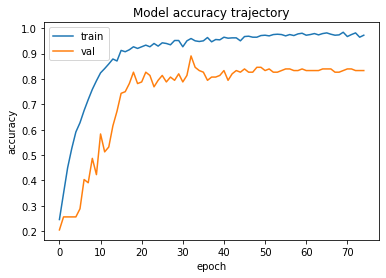

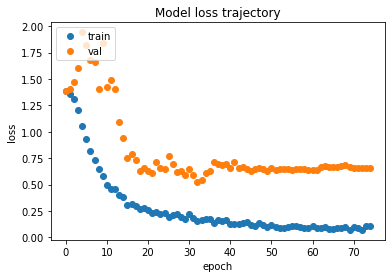

Test accuracy of the model: 0.7021276354789734
Test accuracy of the model: 0.30530473589897156
Test accuracy of the model: 0.23000000417232513
Test accuracy of the model: 0.23999999463558197
Test accuracy of the model: 0.36000001430511475
Test accuracy of the model: 0.125
Test accuracy of the model: 0.3617021143436432
Test accuracy of the model: 0.31122449040412903
Test accuracy of the model: 0.27000001072883606
Test accuracy of the model: 0.17000000178813934


In [81]:
#####################################################################
## Model for **best person** classification; Optimized for Subject 9: 
#####################################################################
person = 8   #Subject 9 (index starts from 0)

## Preprocess the dataset 
y_train, y_valid, y_test, x_train, x_valid, x_test = preprocessing(X_train_valid, Y_train_valid, X_test, Y_test)
yp_train, yp_valid, yp_test, xp_train, xp_valid, xp_test = preprocessing(Xp_train_valid[person], Yp_train_valid[person], Xp_test[person], Yp_test[person])

## Build the Model 
model = Sequential() 

#Insert Model HERE 
# Conv. block 1
model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
model.add(BatchNormalization())
model.add(Dropout(0.5))

## Conv. block 2
model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Stacked GRUs 
model.add(Flatten()) 
model.add(Dense(32))
model.add(Dropout(0.5))
model.add(Reshape((32,1)))
model.add(GRU(16, return_sequences=True, recurrent_dropout=0.1, input_shape=(32,1)))
model.add(Dropout(0.1))
#model.add(GRU(20, return_sequences=True, recurrent_dropout=0.1))
#model.add(Dropout(dropout))
model.add(Bidirectional(GRU(16, return_sequences=True, recurrent_dropout=0.1)))
model.add(Dropout(0.1))
model.add(GRU(10))

# Output Layer with Softmax Activation
model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

model.summary() 

## Specify Model Parameters 
model_optimizer = keras.optimizers.Adam(learning_rate = 1e-3) 

## Compiling, Training, and Validating the Model 
model.compile(loss='categorical_crossentropy', optimizer=model_optimizer, metrics=['accuracy'])

checkpoint_filepath = r'C:\Users\zacha\OneDrive - UCLA IT Services\Documents\ZW - Academic\UCLA\UCLA MAE GRAD CLASSES\ECE C247 - Deep Learning\Final_Project\project\tmp\checkpoint{0}'.format(num)
valloss_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.5)  # reduces by a factor of 0.5 if validation loss doesn't improve for 10 epochs
model_results = model.fit(xp_train, yp_train,
                batch_size=64,  #Default is 64
                epochs=75,
                validation_data=(xp_valid, yp_valid), 
                callbacks=[valloss_callback, lr_callback], verbose=True)

## Visualizing the Accuracy and Loss Trajectory 
# Plotting accuracy trajectory
plt.plot(model_results.history['accuracy'])
plt.plot(model_results.history['val_accuracy'])
plt.title('Model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(model_results.history['loss'],'o')
plt.plot(model_results.history['val_loss'],'o')
plt.title('Model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Testing Performance of the Model on the Subject 
model_score = model.evaluate(xp_test, yp_test, verbose=0)
print('Test accuracy of the model:',model_score[1])

## Testing Performance of the Model on the Entire Dataset
model_score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the model:',model_score[1])
    
## Testing Performance of the Model on other Individual Subjects 
for person in range(8): 
    yp_train, yp_valid, yp_test, xp_train, xp_valid, xp_test = preprocessing(Xp_train_valid[person], Yp_train_valid[person], Xp_test[person], Yp_test[person])
    model_score = model.evaluate(xp_test, yp_test, verbose=0)
    print('Test accuracy of the model:',model_score[1])

Text(0.5, 1.0, 'Stacked GRU + Bidirectionality')

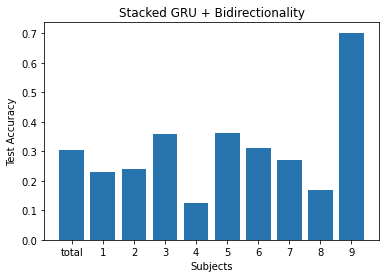

In [86]:
subjects = ['total', '1', '2', '3', '4', '5', '6', '7', '8', '9']
person_test = [0.3053, 0.2300, 0.2400, 0.3600, 0.1250, 0.3617, 0.3112, 0.2700, 0.1700, 0.7021]

plt.bar(subjects, person_test, color='#2774AE')
plt.xlabel("Subjects")
plt.ylabel("Test Accuracy")
plt.title("Stacked GRU + Bidirectionality")

Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_199 (Conv2D)         (None, 500, 1, 25)        5525      
                                                                 
 max_pooling2d_199 (MaxPooli  (None, 167, 1, 25)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_199 (Ba  (None, 167, 1, 25)       100       
 tchNormalization)                                               
                                                                 
 dropout_398 (Dropout)       (None, 167, 1, 25)        0         
                                                                 
 conv2d_200 (Conv2D)         (None, 167, 1, 50)        12550     
                                                                 
 max_pooling2d_200 (MaxPooli  (None, 56, 1, 50)      

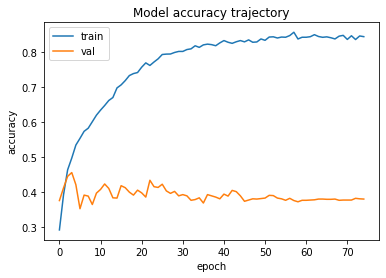

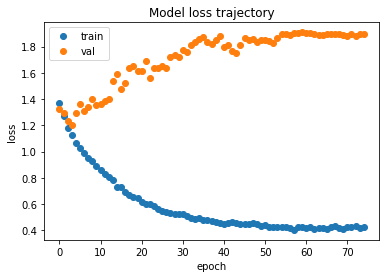

Test accuracy of the model: 0.43792325258255005


In [111]:
###############################################
## Model for **entire dataset** classification 
##############################################
## Preprocess the dataset 
y_train, y_valid, y_test, x_train, x_valid, x_test = preprocessing(X_train_valid, Y_train_valid, X_test, Y_test, trim=1000)

## Build the Model 
model = Sequential() 

#Insert Model HERE 
# Conv. block 1
model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(500,1,22)))
model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
model.add(BatchNormalization())
model.add(Dropout(0.5))

## Conv. block 2
model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Stacked GRUs 
model.add(Flatten()) 
model.add(Dense(32))
model.add(Dropout(0.5))
model.add(Reshape((32,1)))
model.add(GRU(16, return_sequences=True, recurrent_dropout=0.1, input_shape=(32,1)))
model.add(Dropout(0.1))
#model.add(GRU(20, return_sequences=True, recurrent_dropout=0.1))
#model.add(Dropout(dropout))
model.add(Bidirectional(GRU(16, return_sequences=True, recurrent_dropout=0.1)))
model.add(Dropout(0.1))
model.add(GRU(10))

# Output Layer with Softmax Activation
model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

model.summary() 

## Specify Model Parameters 
model_optimizer = keras.optimizers.Adam(learning_rate = 1e-3) 

## Compiling, Training, and Validating the Model 
model.compile(loss='categorical_crossentropy', optimizer=model_optimizer, metrics=['accuracy'])

checkpoint_filepath = r'C:\Users\zacha\OneDrive - UCLA IT Services\Documents\ZW - Academic\UCLA\UCLA MAE GRAD CLASSES\ECE C247 - Deep Learning\Final_Project\project\tmp\checkpoint{0}'.format(num)
valloss_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.5)  # reduces by a factor of 0.5 if validation loss doesn't improve for 10 epochs
model_results = model.fit(x_train, y_train,
                batch_size=64,  #Default is 64
                epochs=75,
                validation_data=(x_valid, y_valid), 
                callbacks=[valloss_callback, lr_callback], verbose=True)

## Visualizing the Accuracy and Loss Trajectory 
# Plotting accuracy trajectory
plt.plot(model_results.history['accuracy'])
plt.plot(model_results.history['val_accuracy'])
plt.title('Model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(model_results.history['loss'],'o')
plt.plot(model_results.history['val_loss'],'o')
plt.title('Model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Testing Performance of the Model on the Entire Dataset 
model_score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the model:',model_score[1])

## Hybrid CNN-LSTM Model 

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_155 (Conv2D)         (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d_155 (MaxPooli  (None, 84, 1, 25)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_155 (Ba  (None, 84, 1, 25)        100       
 tchNormalization)                                               
                                                                 
 dropout_336 (Dropout)       (None, 84, 1, 25)         0         
                                                                 
 conv2d_156 (Conv2D)         (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_156 (MaxPooli  (None, 28, 1, 50)      

Epoch 30/75
12/12 [==============================] - 2s 144ms/step - loss: 0.5811 - accuracy: 0.7318 - val_loss: 1.2856 - val_accuracy: 0.5000 - lr: 5.0000e-04
Epoch 31/75
12/12 [==============================] - 2s 138ms/step - loss: 0.5593 - accuracy: 0.7448 - val_loss: 1.1885 - val_accuracy: 0.6090 - lr: 5.0000e-04
Epoch 32/75
12/12 [==============================] - 2s 142ms/step - loss: 0.5461 - accuracy: 0.7682 - val_loss: 1.2954 - val_accuracy: 0.5256 - lr: 5.0000e-04
Epoch 33/75
12/12 [==============================] - 2s 150ms/step - loss: 0.5739 - accuracy: 0.7435 - val_loss: 1.4079 - val_accuracy: 0.4936 - lr: 5.0000e-04
Epoch 34/75
12/12 [==============================] - 2s 172ms/step - loss: 0.5545 - accuracy: 0.7500 - val_loss: 1.2845 - val_accuracy: 0.5449 - lr: 5.0000e-04
Epoch 35/75
12/12 [==============================] - 2s 145ms/step - loss: 0.5578 - accuracy: 0.7487 - val_loss: 1.2587 - val_accuracy: 0.5769 - lr: 5.0000e-04
Epoch 36/75
12/12 [=====================

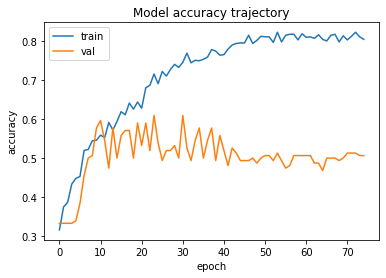

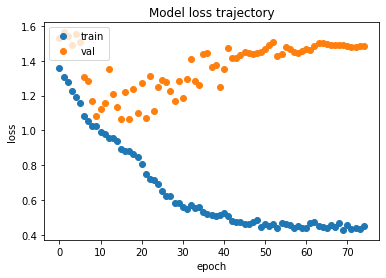

Test accuracy of the model: 0.585106372833252
Test accuracy of the model: 0.32223474979400635
Test accuracy of the model: 0.3149999976158142
Test accuracy of the model: 0.23999999463558197
Test accuracy of the model: 0.36000001430511475
Test accuracy of the model: 0.12999999523162842
Test accuracy of the model: 0.38297873735427856
Test accuracy of the model: 0.37755101919174194
Test accuracy of the model: 0.23499999940395355
Test accuracy of the model: 0.3050000071525574


In [92]:
#####################################################################
## Model for **best person** classification; Optimized for Subject 9: 
#####################################################################
num = 63
person = 8   #Subject 9 (index starts from 0)

## Preprocess the dataset 
y_train, y_valid, y_test, x_train, x_valid, x_test = preprocessing(X_train_valid, Y_train_valid, X_test, Y_test)
yp_train, yp_valid, yp_test, xp_train, xp_valid, xp_test = preprocessing(Xp_train_valid[person], Yp_train_valid[person], Xp_test[person], Yp_test[person])

#Insert Model HERE 
# Building the CNN model using sequential class
model = Sequential()

# Conv. block 1
model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Conv. block 2
model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Conv. block 3
model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Conv. block 4
model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# FC+LSTM layers
model.add(Flatten()) # Adding a flattening operation to the output of CNN block
model.add(Dense((100))) # FC layer with 100 units
model.add(Reshape((100,1))) # Reshape my output of FC layer so that it's compatible
model.add(LSTM(10, dropout=0.6, recurrent_dropout=0.1, input_shape=(80,1), return_sequences=False))

# Output layer with Softmax activation 
model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

# Printing the model summary
model.summary()

## Specify Model Parameters 
model_optimizer = keras.optimizers.Adam(learning_rate = 1e-3) 

## Compiling, Training, and Validating the Model 
model.compile(loss='categorical_crossentropy', optimizer=model_optimizer, metrics=['accuracy'])

checkpoint_filepath = r'C:\Users\zacha\OneDrive - UCLA IT Services\Documents\ZW - Academic\UCLA\UCLA MAE GRAD CLASSES\ECE C247 - Deep Learning\Final_Project\project\tmp\checkpoint{0}'.format(num)
valloss_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.5)  # reduces by a factor of 0.5 if validation loss doesn't improve for 10 epochs
model_results = model.fit(xp_train, yp_train,
                batch_size=64,  #Default is 64
                epochs=50,
                validation_data=(xp_valid, yp_valid), 
                callbacks=[valloss_callback, lr_callback], verbose=True)

## Visualizing the Accuracy and Loss Trajectory 
# Plotting accuracy trajectory
plt.plot(model_results.history['accuracy'])
plt.plot(model_results.history['val_accuracy'])
plt.title('Model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(model_results.history['loss'],'o')
plt.plot(model_results.history['val_loss'],'o')
plt.title('Model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Testing Performance of the Model on the Subject 
model_score = model.evaluate(xp_test, yp_test, verbose=0)
print('Test accuracy of the model:',model_score[1])

## Testing Performance of the Model on the Entire Dataset
model_score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the model:',model_score[1])
    
## Testing Performance of the Model on other Individual Subjects 
for person in range(8): 
    yp_train, yp_valid, yp_test, xp_train, xp_valid, xp_test = preprocessing(Xp_train_valid[person], Yp_train_valid[person], Xp_test[person], Yp_test[person])
    model_score = model.evaluate(xp_test, yp_test, verbose=0)
    print('Test accuracy of the model:',model_score[1])

Text(0.5, 1.0, 'Hybrid CNN-LSTM')

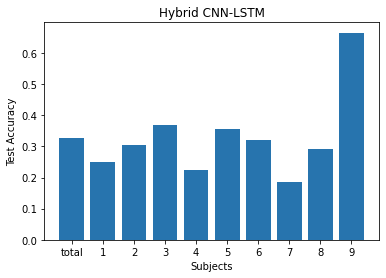

In [91]:
## For 50 Epochs 
subjects = ['total', '1', '2', '3', '4', '5', '6', '7', '8', '9']
person_test = [0.3279, 0.25, 0.305, 0.37, 0.225, 0.3564, 0.3214, 0.185, 0.290, 0.6649]

plt.bar(subjects, person_test, color='#2774AE')
plt.xlabel("Subjects")
plt.ylabel("Test Accuracy")
plt.title("Hybrid CNN-LSTM")

Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_201 (Conv2D)         (None, 500, 1, 25)        5525      
                                                                 
 max_pooling2d_201 (MaxPooli  (None, 167, 1, 25)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_201 (Ba  (None, 167, 1, 25)       100       
 tchNormalization)                                               
                                                                 
 dropout_403 (Dropout)       (None, 167, 1, 25)        0         
                                                                 
 conv2d_202 (Conv2D)         (None, 167, 1, 50)        12550     
                                                                 
 max_pooling2d_202 (MaxPooli  (None, 56, 1, 50)      

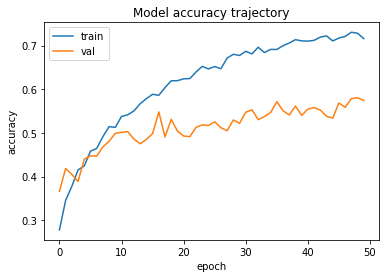

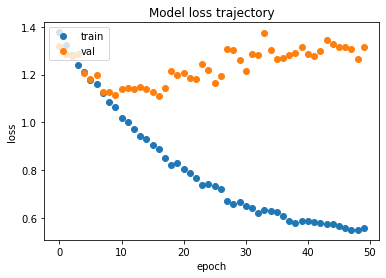

Test accuracy of the model: 0.44130924344062805


In [114]:
#####################################################################
## Model for **full dataset** Optimization  
#####################################################################
num = 64
person = 8   #Subject 9 (index starts from 0)

## Preprocess the dataset 
y_train, y_valid, y_test, x_train, x_valid, x_test = preprocessing(X_train_valid, Y_train_valid, X_test, Y_test, trim=1000)
yp_train, yp_valid, yp_test, xp_train, xp_valid, xp_test = preprocessing(Xp_train_valid[person], Yp_train_valid[person], Xp_test[person], Yp_test[person])

#Insert Model HERE 
# Building the CNN model using sequential class
model = Sequential()

# Conv. block 1
model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(500,1,22)))
model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Conv. block 2
model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Conv. block 3
model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Conv. block 4
model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# FC+LSTM layers
model.add(Flatten()) # Adding a flattening operation to the output of CNN block
model.add(Dense((100))) # FC layer with 100 units
model.add(Reshape((100,1))) # Reshape my output of FC layer so that it's compatible
model.add(LSTM(10, dropout=0.6, recurrent_dropout=0.1, input_shape=(80,1), return_sequences=False))

# Output layer with Softmax activation 
model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

# Printing the model summary
model.summary()

## Specify Model Parameters 
model_optimizer = keras.optimizers.Adam(learning_rate = 1e-3) 

## Compiling, Training, and Validating the Model 
model.compile(loss='categorical_crossentropy', optimizer=model_optimizer, metrics=['accuracy'])

checkpoint_filepath = r'C:\Users\zacha\OneDrive - UCLA IT Services\Documents\ZW - Academic\UCLA\UCLA MAE GRAD CLASSES\ECE C247 - Deep Learning\Final_Project\project\tmp\checkpoint{0}'.format(num)
valloss_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.5)  # reduces by a factor of 0.5 if validation loss doesn't improve for 10 epochs
model_results = model.fit(x_train, y_train,
                batch_size=64,  #Default is 64
                epochs=50,
                validation_data=(x_valid, y_valid), 
                callbacks=[valloss_callback, lr_callback], verbose=True)

## Visualizing the Accuracy and Loss Trajectory 
# Plotting accuracy trajectory
plt.plot(model_results.history['accuracy'])
plt.plot(model_results.history['val_accuracy'])
plt.title('Model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(model_results.history['loss'],'o')
plt.plot(model_results.history['val_loss'],'o')
plt.title('Model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Testing Performance of the Model on the Subject 
#model_score = model.evaluate(xp_test, yp_test, verbose=0)
#print('Test accuracy of the model:',model_score[1])

## Testing Performance of the Model on the Entire Dataset
model_score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the model:',model_score[1])
    
## Testing Performance of the Model on other Individual Subjects 
#for person in range(8): 
#    yp_train, yp_valid, yp_test, xp_train, xp_valid, xp_test = preprocessing(Xp_train_valid[person], Yp_train_valid[person], Xp_test[person], Yp_test[person])
#    model_score = model.evaluate(xp_test, yp_test, verbose=0)
#    print('Test accuracy of the model:',model_score[1])

## CNN 

In [122]:
def NN_model(num, Xtv, Ytv, Xt, Yt, lr=1e-3, epochs=50, batch=64, dropout=0.1, trim=500):
    #print(Xtv.shape)
    #print(Ytv.shape)
    #print(Xt.shape)
    #print(Yt.shape)
    #
    ## Preprocess the dataset 
    y_train, y_valid, y_test, x_train, x_valid, x_test = preprocessing(Xtv, Ytv, Xt, Yt, trim)
    
    # Building the CNN model using sequential class
    model = Sequential()
    
    # Conv. block 1
    model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(int(trim/2),1,22)))
    model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    # Conv. block 2
    model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
    model.add(MaxPooling2D(pool_size=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    # Conv. block 3
    model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    # Conv. block 4
    model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
    model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    # Output layer with Softmax activation
    model.add(Flatten()) # Flattens the input
    model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation
    
    
    # Printing the model summary
    model.summary()
    
    ## Specify Model Parameters 
    model_optimizer = keras.optimizers.Adam(learning_rate = lr) 
    
    ## Compiling, Training, and Validating the Model 
    model.compile(loss='categorical_crossentropy', optimizer=model_optimizer, metrics=['accuracy'])
    
    checkpoint_filepath = r'C:\Users\zacha\OneDrive - UCLA IT Services\Documents\ZW - Academic\UCLA\UCLA MAE GRAD CLASSES\ECE C247 - Deep Learning\Final_Project\project\tmp\checkpoint{0}'.format(num)
    valloss_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)
    lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.5)  # reduces by a factor of 0.5 if validation loss doesn't improve for 10 epochs
    model_results = model.fit(x_train, y_train,
                    batch_size=batch,  #Default is 64
                    epochs=epochs,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[valloss_callback, lr_callback], verbose=True)
    
    ## Visualizing the Accuracy and Loss Trajectory 
    # Plotting accuracy trajectory
    plt.plot(model_results.history['accuracy'])
    plt.plot(model_results.history['val_accuracy'])
    plt.title('Model accuracy trajectory')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # Plotting loss trajectory
    plt.plot(model_results.history['loss'],'o')
    plt.plot(model_results.history['val_loss'],'o')
    plt.title('Model loss trajectory')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    ## Testing Performance of the Model 
    model_score = model.evaluate(x_test, y_test, verbose=0)
    print('Test accuracy of the model:',model_score[1])

Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_214 (Conv2D)         (None, 50, 1, 25)         5525      
                                                                 
 max_pooling2d_213 (MaxPooli  (None, 17, 1, 25)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_213 (Ba  (None, 17, 1, 25)        100       
 tchNormalization)                                               
                                                                 
 dropout_415 (Dropout)       (None, 17, 1, 25)         0         
                                                                 
 conv2d_215 (Conv2D)         (None, 17, 1, 50)         12550     
                                                                 
 max_pooling2d_214 (MaxPooli  (None, 17, 1, 50)      

Epoch 32/50
111/111 [==============================] - 4s 34ms/step - loss: 0.8176 - accuracy: 0.6593 - val_loss: 1.1050 - val_accuracy: 0.5375 - lr: 5.0000e-04
Epoch 33/50
111/111 [==============================] - 4s 34ms/step - loss: 0.8324 - accuracy: 0.6498 - val_loss: 1.1219 - val_accuracy: 0.5297 - lr: 5.0000e-04
Epoch 34/50
111/111 [==============================] - 4s 34ms/step - loss: 0.8121 - accuracy: 0.6707 - val_loss: 1.1480 - val_accuracy: 0.5319 - lr: 5.0000e-04
Epoch 35/50
111/111 [==============================] - 4s 35ms/step - loss: 0.8135 - accuracy: 0.6627 - val_loss: 1.1399 - val_accuracy: 0.5156 - lr: 5.0000e-04
Epoch 36/50
111/111 [==============================] - 4s 37ms/step - loss: 0.8028 - accuracy: 0.6650 - val_loss: 1.1267 - val_accuracy: 0.5276 - lr: 5.0000e-04
Epoch 37/50
111/111 [==============================] - 5s 49ms/step - loss: 0.7980 - accuracy: 0.6755 - val_loss: 1.1002 - val_accuracy: 0.5460 - lr: 5.0000e-04
Epoch 38/50
111/111 [=============

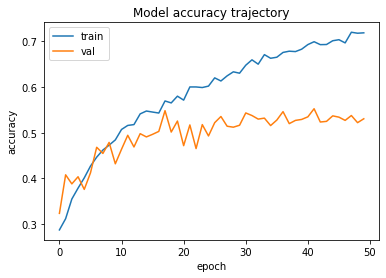

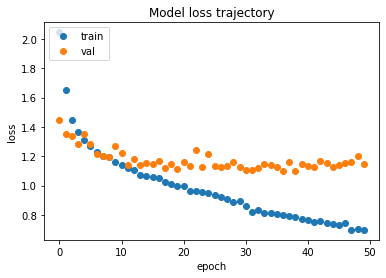

Test accuracy of the model: 0.534424364566803
Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_218 (Conv2D)         (None, 100, 1, 25)        5525      
                                                                 
 max_pooling2d_217 (MaxPooli  (None, 34, 1, 25)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_217 (Ba  (None, 34, 1, 25)        100       
 tchNormalization)                                               
                                                                 
 dropout_419 (Dropout)       (None, 34, 1, 25)         0         
                                                                 
 conv2d_219 (Conv2D)         (None, 34, 1, 50)         12550     
                                                                 
 max_po

Epoch 32/50
111/111 [==============================] - 6s 50ms/step - loss: 0.6647 - accuracy: 0.7372 - val_loss: 0.9468 - val_accuracy: 0.6466 - lr: 0.0010
Epoch 33/50
111/111 [==============================] - 6s 50ms/step - loss: 0.6383 - accuracy: 0.7466 - val_loss: 0.9568 - val_accuracy: 0.6424 - lr: 0.0010
Epoch 34/50
111/111 [==============================] - 5s 47ms/step - loss: 0.6285 - accuracy: 0.7491 - val_loss: 0.9556 - val_accuracy: 0.6501 - lr: 0.0010
Epoch 35/50
111/111 [==============================] - 5s 49ms/step - loss: 0.6279 - accuracy: 0.7523 - val_loss: 0.9240 - val_accuracy: 0.6629 - lr: 0.0010
Epoch 36/50
111/111 [==============================] - 6s 55ms/step - loss: 0.6009 - accuracy: 0.7589 - val_loss: 1.0079 - val_accuracy: 0.6466 - lr: 0.0010
Epoch 37/50
111/111 [==============================] - 6s 57ms/step - loss: 0.5879 - accuracy: 0.7723 - val_loss: 0.9638 - val_accuracy: 0.6445 - lr: 0.0010
Epoch 38/50
111/111 [==============================] - 7s 

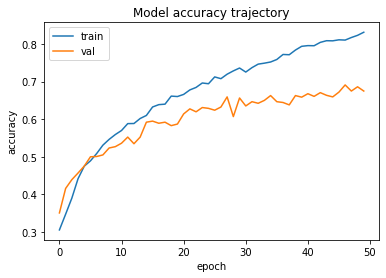

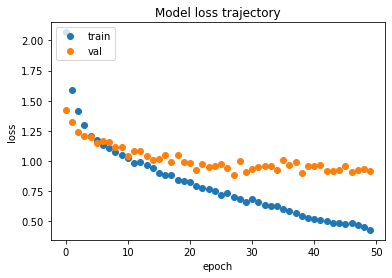

Test accuracy of the model: 0.6653499007225037
Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_222 (Conv2D)         (None, 150, 1, 25)        5525      
                                                                 
 max_pooling2d_221 (MaxPooli  (None, 50, 1, 25)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_221 (Ba  (None, 50, 1, 25)        100       
 tchNormalization)                                               
                                                                 
 dropout_423 (Dropout)       (None, 50, 1, 25)         0         
                                                                 
 conv2d_223 (Conv2D)         (None, 50, 1, 50)         12550     
                                                                 
 max_

Epoch 32/50
111/111 [==============================] - 8s 72ms/step - loss: 0.5324 - accuracy: 0.7934 - val_loss: 0.8976 - val_accuracy: 0.6721 - lr: 0.0010
Epoch 33/50
111/111 [==============================] - 8s 76ms/step - loss: 0.4980 - accuracy: 0.8043 - val_loss: 0.9068 - val_accuracy: 0.6721 - lr: 0.0010
Epoch 34/50
111/111 [==============================] - 8s 73ms/step - loss: 0.4856 - accuracy: 0.8092 - val_loss: 0.9373 - val_accuracy: 0.6544 - lr: 0.0010
Epoch 35/50
111/111 [==============================] - 8s 72ms/step - loss: 0.4367 - accuracy: 0.8340 - val_loss: 0.8841 - val_accuracy: 0.6657 - lr: 5.0000e-04
Epoch 36/50
111/111 [==============================] - 8s 73ms/step - loss: 0.4290 - accuracy: 0.8390 - val_loss: 0.8611 - val_accuracy: 0.6749 - lr: 5.0000e-04
Epoch 37/50
111/111 [==============================] - 8s 72ms/step - loss: 0.4137 - accuracy: 0.8438 - val_loss: 0.8783 - val_accuracy: 0.6693 - lr: 5.0000e-04
Epoch 38/50
111/111 [=========================

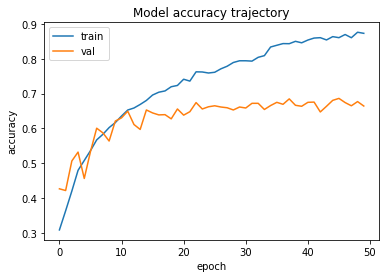

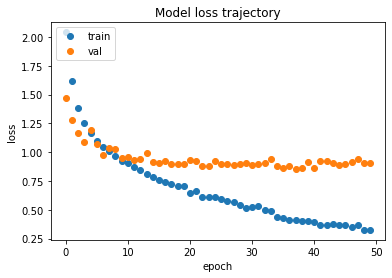

Test accuracy of the model: 0.6930022835731506
Model: "sequential_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_226 (Conv2D)         (None, 200, 1, 25)        5525      
                                                                 
 max_pooling2d_225 (MaxPooli  (None, 67, 1, 25)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_225 (Ba  (None, 67, 1, 25)        100       
 tchNormalization)                                               
                                                                 
 dropout_427 (Dropout)       (None, 67, 1, 25)         0         
                                                                 
 conv2d_227 (Conv2D)         (None, 67, 1, 50)         12550     
                                                                 
 max_

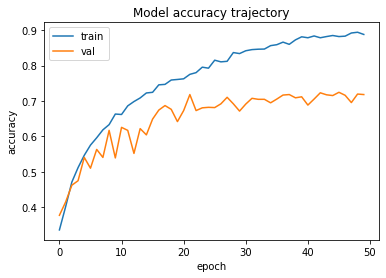

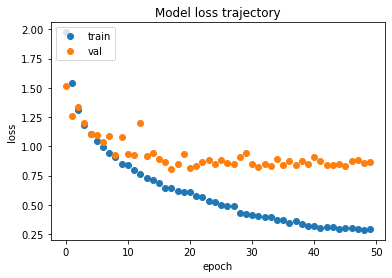

Test accuracy of the model: 0.7172686457633972
Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_230 (Conv2D)         (None, 300, 1, 25)        5525      
                                                                 
 max_pooling2d_229 (MaxPooli  (None, 100, 1, 25)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_229 (Ba  (None, 100, 1, 25)       100       
 tchNormalization)                                               
                                                                 
 dropout_431 (Dropout)       (None, 100, 1, 25)        0         
                                                                 
 conv2d_231 (Conv2D)         (None, 100, 1, 50)        12550     
                                                                 
 max_

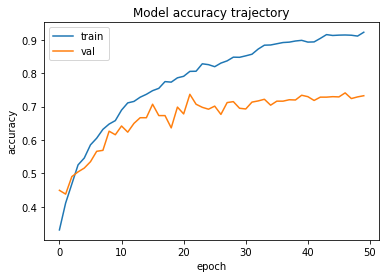

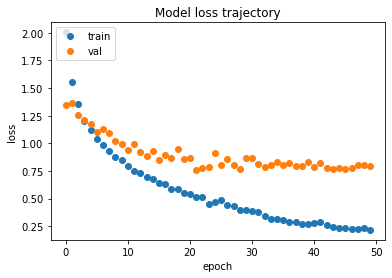

Test accuracy of the model: 0.7144469618797302
Model: "sequential_103"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_234 (Conv2D)         (None, 500, 1, 25)        5525      
                                                                 
 max_pooling2d_233 (MaxPooli  (None, 167, 1, 25)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_233 (Ba  (None, 167, 1, 25)       100       
 tchNormalization)                                               
                                                                 
 dropout_435 (Dropout)       (None, 167, 1, 25)        0         
                                                                 
 conv2d_235 (Conv2D)         (None, 167, 1, 50)        12550     
                                                                 
 max_

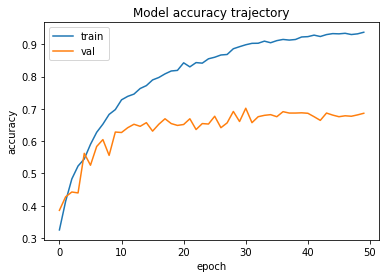

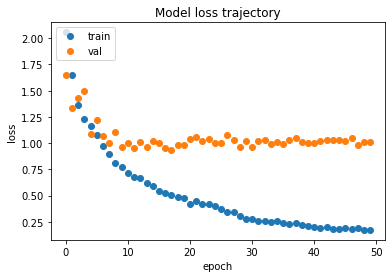

Test accuracy of the model: 0.6726862192153931


In [123]:
## Loading the dataset
X_test = np.load("X_test.npy")
Y_test = np.load("y_test.npy")
person_test = np.load("person_test.npy")
X_train_valid = np.load("X_train_valid.npy")
Y_train_valid = np.load("y_train_valid.npy")
person_train_valid = np.load("person_train_valid.npy")

## Adjust the dataset labels to be 0,1,2,3
Y_train_valid -= 769
Y_test -= 769 

trim = [100, 200, 300, 400, 600, 1000]
for t in trim:
    NN_model(num, X_train_valid, Y_train_valid, X_test, Y_test, trim=t)

## ResCNN 

In [135]:
def ResCNN_model(num, Xtv, Ytv, Xt, Yt, lr=1e-3, epochs=50, batch=64, dropout=0.1, trim=500):
    #print(Xtv.shape)
    #print(Ytv.shape)
    #print(Xt.shape)
    #print(Yt.shape)
    #
    ## Preprocess the dataset 
    y_train, y_valid, y_test, x_train, x_valid, x_test = preprocessing(Xtv, Ytv, Xt, Yt, trim)
    print(y_train.shape)
    print(trim)
    
    # Building the CNN model using sequential class
    inputs = keras.Input(shape=(50,1,22), name='eeg')
    
    # Conv. block 1
    block_1 = Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', name='conv1')(inputs)
    block_1 = MaxPooling2D(pool_size=(3,1), padding='same')(block_1)
    block_1 = BatchNormalization()(block_1)
    block_1 = Dropout(0.5)(block_1)
    
    # Conv. block 2
    block_2 = Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', name='conv2')(block_1)
    block_2 = MaxPooling2D(pool_size=(1,1), padding='same')(block_2)
    block_2 = BatchNormalization()(block_2)
    block_2 = Dropout(0.5)(block_2)
    
    # Conv. block 3
    block_3 = keras.layers.add([block_1, block_2])
    block_3 = Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu', name='conv3')(block_3)
    block_3 = MaxPooling2D(pool_size=(3,1), padding='same')(block_3)
    block_3 = BatchNormalization()(block_3)
    block_3 = Dropout(0.5)(block_3)
    
    # Conv. block 4
    block_4 = Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu', name='conv4')(block_3)
    block_4 = MaxPooling2D(pool_size=(1,1), padding='same')(block_4)
    block_4 = BatchNormalization()(block_4)
    block_4 = Dropout(0.5)(block_4)
    
    # Conv. block 5
    block_5 = keras.layers.add([block_3, block_4])
    block_5 = Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu', name='conv5')(block_5)
    block_5 = MaxPooling2D(pool_size=(3,1), padding='same')(block_5)
    block_5 = BatchNormalization()(block_5)
    block_5 = Dropout(0.5)(block_5)
    
    # Output layer with Softmax activation
    x = keras.layers.Flatten()(block_5)
    
    # Output layer with Softmax activation 
    probs = keras.layers.Dense(4, activation='softmax')(x) # Output FC layer with softmax activation
    
    # Printing the model summary
    res_cnn_model = keras.Model(inputs=inputs, outputs=probs, name='eeg_resnet')
    res_cnn_model.summary()
    
    ## Specify Model Parameters 
    model_optimizer = keras.optimizers.Adam(learning_rate = lr) 
    
    ## Compiling, Training, and Validating the Model 
    model.compile(loss='categorical_crossentropy', optimizer=model_optimizer, metrics=['accuracy'])
    
    checkpoint_filepath = r'C:\Users\zacha\OneDrive - UCLA IT Services\Documents\ZW - Academic\UCLA\UCLA MAE GRAD CLASSES\ECE C247 - Deep Learning\Final_Project\project\tmp\checkpoint{0}'.format(num)
    valloss_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)
    lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.5)  # reduces by a factor of 0.5 if validation loss doesn't improve for 10 epochs
    model_results = model.fit(x_train, y_train,
                    batch_size=batch,  #Default is 64
                    epochs=epochs,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[valloss_callback, lr_callback], verbose=True)
    
    ## Visualizing the Accuracy and Loss Trajectory 
    # Plotting accuracy trajectory
    plt.plot(model_results.history['accuracy'])
    plt.plot(model_results.history['val_accuracy'])
    plt.title('Model accuracy trajectory')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # Plotting loss trajectory
    plt.plot(model_results.history['loss'],'o')
    plt.plot(model_results.history['val_loss'],'o')
    plt.title('Model loss trajectory')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    ## Testing Performance of the Model 
    model_score = model.evaluate(x_test, y_test, verbose=0)
    print('Test accuracy of the model:',model_score[1])

In [136]:
## Loading the dataset
X_test = np.load("X_test.npy")
Y_test = np.load("y_test.npy")
person_test = np.load("person_test.npy")
X_train_valid = np.load("X_train_valid.npy")
Y_train_valid = np.load("y_train_valid.npy")
person_train_valid = np.load("person_train_valid.npy")

## Adjust the dataset labels to be 0,1,2,3
Y_train_valid -= 769
Y_test -= 769 

trim = [100, 200, 300, 400, 600, 1000]
for t in trim:
    print(t)
    ResCNN_model(num, X_train_valid, Y_train_valid, X_test, Y_test, trim=t)

100
(7048, 4)
100
Model: "eeg_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 eeg (InputLayer)               [(None, 50, 1, 22)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 50, 1, 25)    5525        ['eeg[0][0]']                    
                                                                                                  
 max_pooling2d_252 (MaxPooling2  (None, 17, 1, 25)   0           ['conv1[0][0]']                  
 D)                                                                                               
                                                                                                  
 batch_normalization_252 (Batch  (None, 17, 1, 25)   100         ['max_

ValueError: in user code:

    File "C:\Users\zacha\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\zacha\anaconda3\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\zacha\anaconda3\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\zacha\anaconda3\lib\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\zacha\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\zacha\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_94" is incompatible with the layer: expected shape=(None, 500, 1, 22), found shape=(None, 50, 1, 22)


## Results 

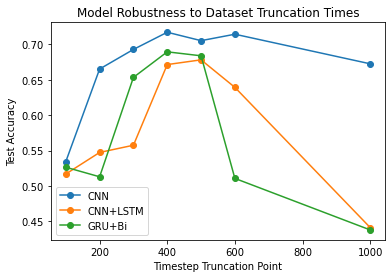

In [142]:
##QUESTION 3: Impact of Truncation Times 
t = [100, 200, 300, 400, 500, 600, 1000]
CNN = [0.5344, 0.6653, 0.6930, 0.7173, 0.7054, 0.7145, 0.6727]
ResCNN = [] 
CNNLSTM = [0.5169, 0.5474, 0.5576, 0.6716, 0.6783, 0.6394, 0.4413]
GRU = [0.5265, 0.5130, 0.6535, 0.6896, 0.6840, 0.5107, 0.4379]

plt.plot(t,CNN, label='CNN', marker='o')
plt.plot(t,CNNLSTM, label='CNN+LSTM', marker='o')
plt.plot(t,GRU, label='GRU+Bi', marker='o')
plt.xlabel("Timestep Truncation Point")
plt.ylabel("Test Accuracy")
plt.title("Model Robustness to Dataset Truncation Times")
plt.legend()

In [ ]:
### Model Complexity (500 Timestep Input)

Total params: 101,304
Trainable params: 100,804

### Model (Dense 100 3x GRU 64-32-10)
|Model#|Batch|Dropout|Epochs|LR|TestAcc1|TestAcc2|MinValLoss|Epoch| 
|------|-----|-------|------|--|--------|--------|----------|-----|
|0|32 |0.1|50|1e-3|0.6309|0.6287|0.9084|8 |
|1|32 |0.3|50|1e-3|0.6236|0.6259|0.9024|8 |
|2|32 |0.6|50|1e-3|0.6309|0.6332|0.9690|6 |
|3|64 |0.1|50|1e-3|0.6552|0.6637|0.8254|10|
|9|64 |0.2|50|1e-3|0.6292|      |1.0405|9 |
|4|64 |0.3|50|1e-3|0.6388|0.6270|0.9402|11|
|5|64 |0.6|50|1e-3|0.5745|0.5745|1.0289|6 |
|6|128|0.1|50|1e-3|0.5756|0.5880|1.0100|11|
|7|128|0.3|50|1e-3|0.6163|0.6270|1.0105|14|
|8|128|0.6|50|1e-3|0.6473|0.6253|1.0573|12|

NOTE: I stopped training after 3 runs because I noticed characteristics of overfitting - the training accuracy continues to decrease while validation accuracy reaches a min early and then increases. 

0: loss: 0.0833 - accuracy: 0.9730 - val_loss: 1.2708 - val_accuracy: 0.6693 - lr: 6.2500e-05
1: loss: 0.0814 - accuracy: 0.9718 - val_loss: 1.3708 - val_accuracy: 0.6565 - lr: 6.2500e-05
2: loss: 0.1589 - accuracy: 0.9454 - val_loss: 1.4022 - val_accuracy: 0.6381 - lr: 6.2500e-05
3: loss: 0.1029 - accuracy: 0.9651 - val_loss: 1.1427 - val_accuracy: 0.6834 - lr: 1.2500e-04
4: loss: 0.1572 - accuracy: 0.9455 - val_loss: 1.1969 - val_accuracy: 0.6700 - lr: 1.2500e-04
5: loss: 0.2311 - accuracy: 0.9190 - val_loss: 1.3947 - val_accuracy: 0.5871 - lr: 6.2500e-05
6: loss: 0.1480 - accuracy: 0.9495 - val_loss: 1.3344 - val_accuracy: 0.6452 - lr: 1.2500e-04
7: loss: 0.1507 - accuracy: 0.9471 - val_loss: 1.2346 - val_accuracy: 0.6686 - lr: 1.2500e-04
8: loss: 0.1297 - accuracy: 0.9573 - val_loss: 1.5791 - val_accuracy: 0.6048 - lr: 1.2500e-04
9: loss: 0.1104 - accuracy: 0.9615 - val_loss: 1.4112 - val_accuracy: 0.6360 - lr: 6.2500e-05


### Model (Dense 50 3x GRU 32-32-10) 
|Model#|Batch|Dropout|Epochs|LR|ValAcc|TestAcc1|TestAcc2|MinValLoss|Epoch| 
|------|-----|-------|------|--|------|--------|--------|----------|-----|
|10|64|0.2|50|1e-3|0.6417||1.0165|16|
|11|64|0.1|50|1e-3|0.6337||0.8088|10|
|13|64|0.1|50|1e-3|0.6275|0.6174|1.0001|10|
|15|64|0.1|50|1e-3|0.6095|0.5570|1.0704|7 |

*ValAcc at Epoch 10 for Model 11 was 0.7224
*At and after Model 13, I switched to a Val_Loss callback 

10: loss: 0.1226 - accuracy: 0.9581 - val_loss: 1.2504 - val_accuracy: 0.6601 - lr: 1.2500e-04

### Model (Dense N 3x GRU 16-16-10) 
|Model#|Batch|Dropout|Epochs|LR|N|TestAcc1|TestAcc2|MinValLoss|Epoch| 
|------|-----|-------|------|--|-|--------|--------|----------|-----|
|12|64|0.2|50|1e-3|25|0.6417||0.9148|12|
|**14**|64|0.1|50|1e-3|32|0.6812||0.8612|17|
|18|64|0.1|50|1e-3|25|0.6202||0.9868|33|
|21|64|0.1|50|1e-3|32|0.6242||0.8533|15|
|22|64|0.1|25|1e-3|32|0.5807||1.1478|4|
|23|64|0.1|50|1e-3|32|0.6620|0.6840|0.8494|35|
|24|64|0.1|50|1e-3|32|0.5937|0.6315|0.7873|40|
|25|64|0.1|50|1e-3|32|0.6321|0.5660|1.0991|13|
|26|64|0.1|50|1e-3|32|0.5379|0.6552|0.7671|21|
|27|64|0.1|50|1e-3|32|0.6558|0.6670|0.8967|23|
|28|64|0.1|50|1e-3|32|0.6405|0.5976|1.0610|16|
|29|64|0.1|50|1e-3|32|0.6637|0.6281|1.0402|14|
|31|  |   |  |    |  |0.5243|0.5948|0.9347|19|
|32|

14: loss: 0.1382 - accuracy: 0.9469 - val_loss: 1.0476 - val_accuracy: 0.6933 - lr: 1.2500e-04
18: loss: 0.1682 - accuracy: 0.9394 - val_loss: 1.0888 - val_accuracy: 0.6629 - lr: 5.0000e-04
22: loss: 0.3823 - accuracy: 0.8602 - val_loss: 1.4106 - val_accuracy: 0.5595 - lr: 2.5000e-04
24: loss: 0.3209 - accuracy: 0.8837 - val_loss: 0.9229 - val_accuracy: 0.6806 - lr: 0.0010
25: loss: 0.4032 - accuracy: 0.8495 - val_loss: 1.1769 - val_accuracy: 0.6261 - lr: 7.8125e-06
26: loss: 0.3356 - accuracy: 0.8776 - val_loss: 1.0785 - val_accuracy: 0.6084 - lr: 2.5000e-04
27: loss: 0.3405 - accuracy: 0.8750 - val_loss: 0.9328 - val_accuracy: 0.6735 - lr: 1.5625e-05
28: loss: 0.2692 - accuracy: 0.9095 - val_loss: 1.1577 - val_accuracy: 0.6225 - lr: 7.8125e-06
29: 
31: loss: 0.3442 - accuracy: 0.8788 - val_loss: 1.1634 - val_accuracy: 0.5949 - lr: 1.2500e-04

*For all models (unless specified), the second GRU is bidirectional
*Model 21 has no Bidirectionality 
*Val_Loss for Model 12 saturates around 1; much more stable than other cases 
*Model 23 adds a dropout=0.5 layer after the dense layer 
*Model 24,26,27 adds a dropout=0.3 layer after the dense layer
*Model 25 adds a dropout=0.2 layer after the dense layer; changes callback patience to 5
*Model 27,28 changes callback patience to 5
*Model 31 uses 40(0.4);20-20-10

### Model (Dense 32 3x GRU 16-16-10); 2x Bidirectional 
|Model#|Batch|Dropout|Epochs|LR|Bi-Layers|ValAcc|TestAcc1|TestAcc2|MinValLoss|Epoch| 
|------|-----|-------|------|--|---------|------|--------|--------|----------|-----|
|16|64|0.1|50|1e-3|2,3|0.6247|0.6112|0.8677|8 |
|17|64|0.1|50|1e-3|1,2|0.6304|0.6134|0.9089|10|

17: loss: 0.1692 - accuracy: 0.9406 - val_loss: 1.1322 - val_accuracy: 0.6608 - lr: 1.2500e-04
18: loss: 0.1619 - accuracy: 0.9410 - val_loss: 1.1725 - val_accuracy: 0.6664 - lr: 6.2500e-05

### Model (Dense 32 4x GRU 16-16-16-10)
|Model#|Batch|Dropout|Epochs|LR|ValAcc|TestAcc1|TestAcc2|MinValLoss|Epoch| 
|------|-----|-------|------|--|------|--------|--------|----------|-----|
|19|64|0.1|50|1e-3|0.6490|0.6027|0.9206|8|

19: loss: 0.1619 - accuracy: 0.9410 - val_loss: 1.1725 - val_accuracy: 0.6664 - lr: 6.2500e-05

### Model (Dense 32 2x GRU 16-10)
|Model#|Batch|Dropout|Epochs|LR|ValAcc|TestAcc1|TestAcc2|MinValLoss|Epoch| 
|------|-----|-------|------|--|------|--------|--------|----------|-----|
|20|64|0.1|50|1e-3|0.6631|0.6230|0.9337|11|

20: loss: 0.1780 - accuracy: 0.9359 - val_loss: 1.1227 - val_accuracy: 0.6785 - lr: 1.2500e-04

### Model 1 Conv Layer >> (Dense32 3x GRU 16-16-10); 1x Bidirectional
|Model#|Batch|Dropout|Epochs|LR|ValAcc|TestAcc1|TestAcc2|MinValLoss|Epoch| 
|------|-----|-------|------|--|------|--------|--------|----------|-----|

Test accuracy of the model: 0.5270880460739136
Test accuracy of the model: 0.43397292494773865

*This onw was terrible; not worth recording
loss: 0.0571 - accuracy: 0.9810 - val_loss: 1.7903 - val_accuracy: 0.5708 - lr: 6.2500e-05

## Old Code

In [ ]:
num = 14

## Preprocess the entire dataset 
y_train, y_valid, y_test, x_train, x_valid, x_test = preprocessing(X_train_valid, Y_train_valid, X_test, Y_test)

# Building the CNN model using sequential class
model = Sequential()

# Conv. block 1
model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Conv. block 2
model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Stacked GRUs 
model.add(Flatten()) 
model.add(Dense(50))
model.add(Reshape((50,1)))
model.add(GRU(32, return_sequences=True, recurrent_dropout=0.1, input_shape=(50,1))) 
model.add(Dropout(0.1))
model.add(GRU(32, return_sequences=True, recurrent_dropout=0.1)) 
model.add(Dropout(0.1))
model.add(GRU(10))

# Output Layer with Softmax Activation
model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

model.summary()

lr = 1e-3
epochs = 50
model_optimizer = keras.optimizers.Adam(learning_rate=lr)

# Compiling the model
model.compile(loss='categorical_crossentropy',
                 optimizer=model_optimizer,
                 metrics=['accuracy'])

# Use checkpoints to save best validation accuracy model 
checkpoint_filepath = r'C:\Users\zacha\OneDrive - UCLA IT Services\Documents\ZW - Academic\UCLA\UCLA MAE GRAD CLASSES\ECE C247 - Deep Learning\Final_Project\project\tmp\checkpoint{0}'.format(num)
valloss_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.5)  # reduces by a factor of 0.5 if validation loss doesn't improve for 10 epochs

# Training and validating the model
model_results = model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), 
             callbacks=[valloss_callback, lr_callback],
             verbose=True)

# Plotting accuracy trajectory
plt.plot(model_results.history['accuracy'])
plt.plot(model_results.history['val_accuracy'])
plt.title('Model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(model_results.history['loss'],'o')
plt.plot(model_results.history['val_loss'],'o')
plt.title('Model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Testing model 
model_score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',model_score[1])

# Load best validation accuracy weights 
model.load_weights(checkpoint_filepath)
    
model_score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the model:',model_score[1])

In [ ]:
## Preprocess the entire dataset 
y_train, y_valid, y_test, x_train, x_valid, x_test = preprocessing(X_train_valid, Y_train_valid, X_test, Y_test)

# Building the CNN model using sequential class
model = Sequential()

# Conv. block 1
model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Conv. block 2
model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Stacked GRUs 
model.add(Flatten()) 
model.add(Dense(50))
model.add(Reshape((50,1)))
model.add(GRU(32, return_sequences=True, recurrent_dropout=0.1, input_shape=(50,1))) 
model.add(Dropout(0.4))
model.add(GRU(32, return_sequences=True, recurrent_dropout=0.1)) 
model.add(Dropout(0.4))
model.add(GRU(10))

# Output Layer with Softmax Activation
model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

model.summary()

In [ ]:
num = 33 

batch = [32,64,128]  #256, 512
epochs = [25,50,100]
lr = [5e-2, 1e-3, 5e-3]

for b in batch:
    for e in epochs: 
        for l in lr: 
            NN_model(num, X_train_valid, Y_train_valid, X_test, Y_test, lr = l, batch=b, epochs=e)
            num += 1 

In [ ]:
### Running Best Model per person 

num=53

## Preprocess the entire dataset 
y_train, y_valid, yy_test, x_train, x_valid, xx_test = preprocessing(X_train_valid, Y_train_valid, X_test, Y_test)

for p in range(9):
    NN_model(num, Xp_train_valid[p], Yp_train_valid[p], Xp_test[p], Yp_test[p], xx_test, yy_test)
    num += 1 

In [ ]:
epochs = [50, 75, 100, 125]
p = 8

for e in epochs:
    NN_model(num, Xp_train_valid[p], Yp_train_valid[p], Xp_test[p], Yp_test[p], xx_test, yy_test, epochs = e)